## Setup

In [1]:
!pip install openai
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.7 MB/s eta 0:00:00


In [2]:
import textwrap
import json
import tiktoken
#from openai.embeddings_utils import distances_from_embeddings

from scipy import spatial
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import openai
from getpass import getpass
api_key = getpass('Enter the OpenAI API Key in the cell  ')

client = openai.OpenAI(api_key=api_key)
openai.api_key =api_key

Enter the OpenAI API Key in the cell  ··········


## Embeddings + Vector Data Bases

Here we understand the basics behind vector embeddings, and go through some examples.



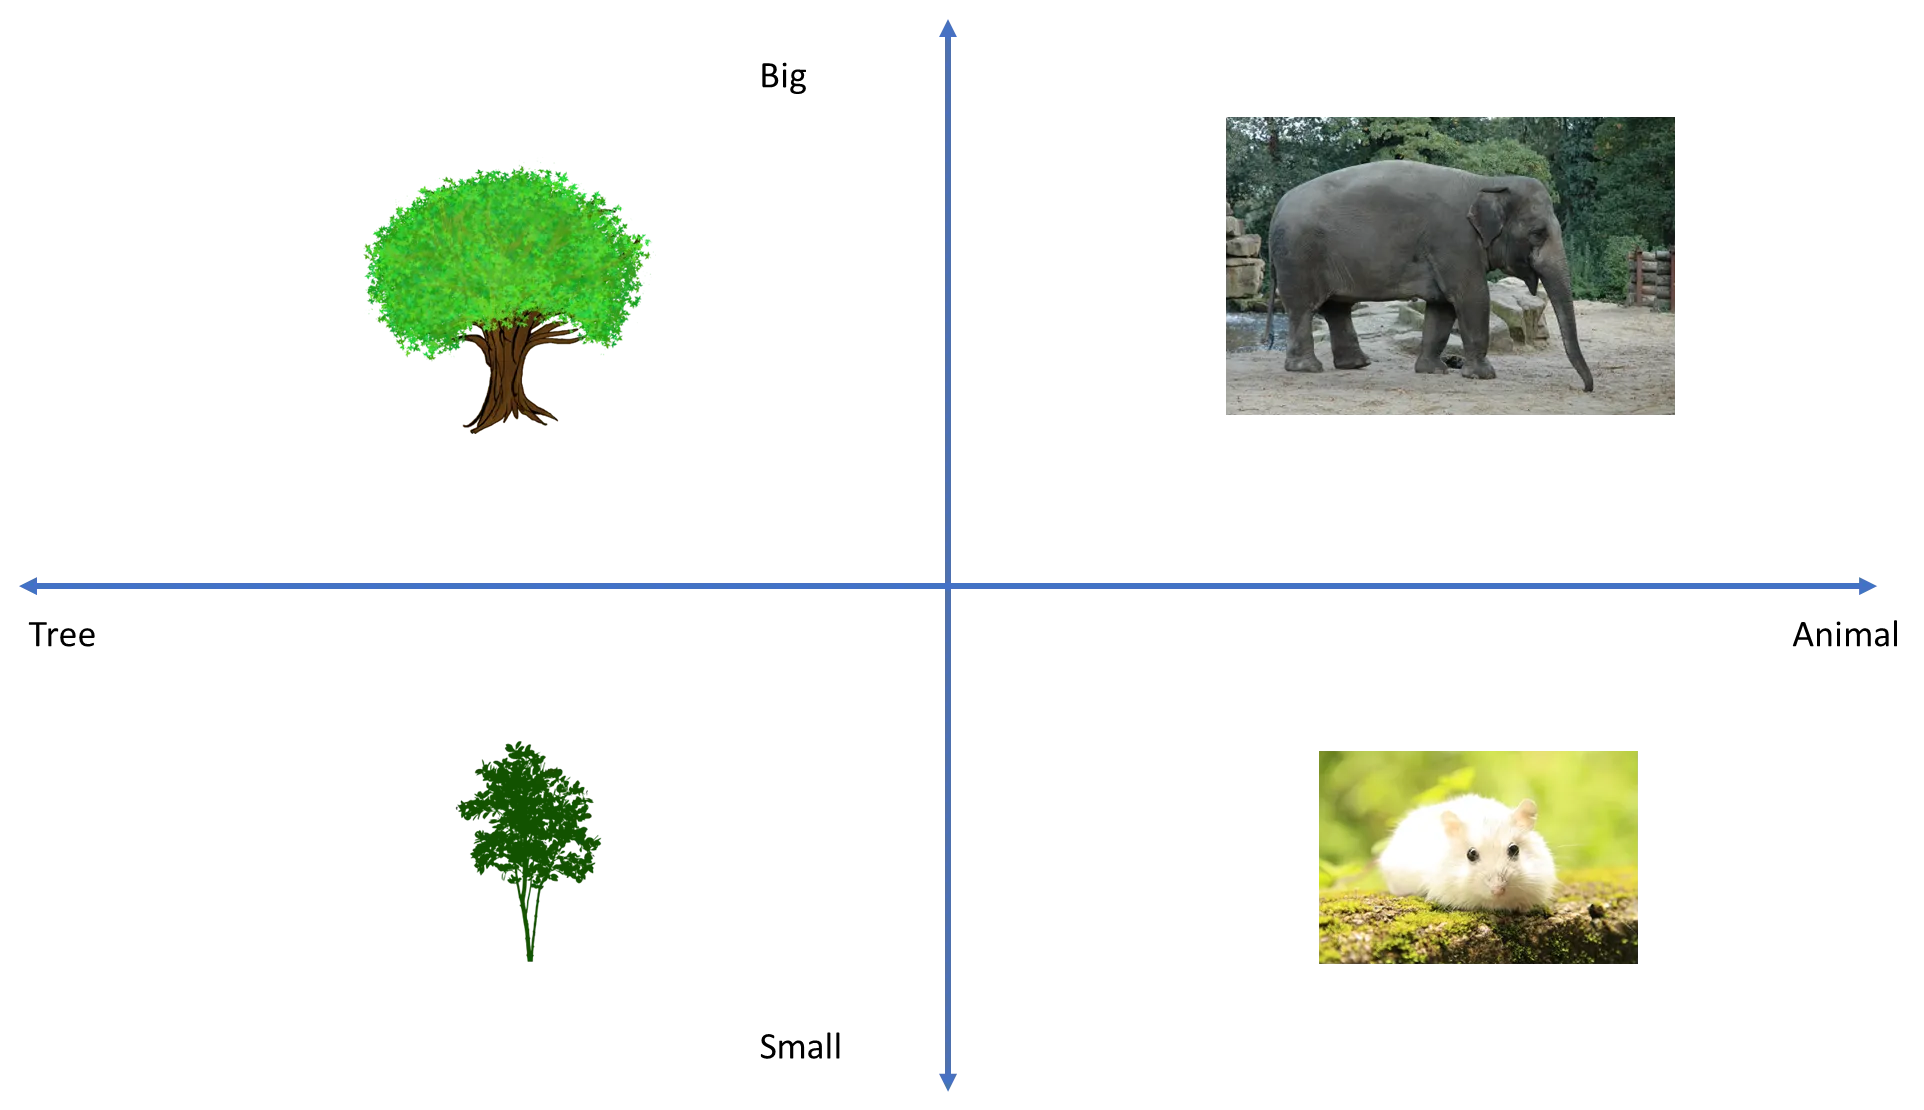

In [4]:
def get_embedding(text, model="text-embedding-ada-002"):
  text = text.replace("\n", " ")
  return client.embeddings.create(input = [text], model=model).data[0].embedding


In [19]:
e1=get_embedding('the boy went to a party')
e2=get_embedding('the boy went to a party')
e3=get_embedding("""We found evidence of bias in our models via running the SEAT (May et al, 2019) and the Winogender (Rudinger et al, 2018) benchmarks. Together, these benchmarks consist of 7 tests that measure whether models contain implicit biases when applied to gendered names, regional names, and some stereotypes.

For example, we found that our models more strongly associate (a) European American names with positive sentiment, when compared to African American names, and (b) negative stereotypes with black women.""")

In [20]:
#cosine similarity of 1.0 means that these chunks are the same
1-spatial.distance.cosine(e1,e2)

1

In [21]:
1-spatial.distance.cosine(e1,e3)

0.6962544948861725

In [10]:
len(e1)

1536

Embeddings to choose the right context

In [25]:
context1="""Net sales increased 9% to $127.4 billion in the first quarter, compared with $116.4 billion in first quarter 2022.
Excluding the $2.4 billion unfavorable impact from year-over-year changes in foreign exchange rates throughout the
quarter, net sales increased 11% compared with first quarter 2022.
• North America segment sales increased 11% year-over-year to $76.9 billion.
• International segment sales increased 1% year-over-year to $29.1 billion, or increased 9% excluding changes
in foreign exchange rates.
• AWS segment sales increased 16% year-over-year to $21.4 billion."""

context2="""• Operating income increased to $4.8 billion in the first quarter, compared with $3.7 billion in first quarter 2022. First
quarter 2023 operating income includes approximately $0.5 billion of charges related to estimated severance costs.
• North America segment operating income was $0.9 billion, compared with operating loss of $1.6 billion in
first quarter 2022.
• International segment operating loss was $1.2 billion, compared with operating loss of $1.3 billion in first
quarter 2022.
• AWS segment operating income was $5.1 billion, compared with operating income of $6.5 billion in first
quarter 2022.
"""

context3="""Net income was $3.2 billion in the first quarter, or $0.31 per diluted share, compared with net loss of $3.8 billion, or
$0.38 per diluted share, in first quarter 2022. All share and per share information for comparable prior year periods
throughout this release have been retroactively adjusted to reflect the 20-for-1 stock split effected on May 27, 2022.
• First quarter 2023 net income includes a pre-tax valuation loss of $0.5 billion included in non-operating
expense from the common stock investment in Rivian Automotive, Inc., compared to a pre-tax valuation loss
of $7.6 billion from the investment in first quarter 2022."""


prompt="""What was the sales increase for Amazon in the first quarter?"""

In [40]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    response = openai.chat.completions.create(
                    model="gpt-3.5-turbo",
                    temperature=0,
        messages=[{"role": "user", "content": prompt}]
    )

    return response.choices[0].message.content

In [41]:
#without feeding the right context, ChatGPT does not have the necessary context to answer this question.
response = get_completion(prompt)
print(response)

The sales increase for Amazon in the first quarter was 9%, with net sales increasing to $127.4 billion compared to $116.4 billion in the first quarter of 2022. Excluding the impact of foreign exchange rates, the net sales increased by 11% compared to the first quarter of 2022.


In [15]:
#The highest cosine similarity indicates that the answer to the question is most likely located in this context
1-spatial.distance.cosine(get_embedding(prompt),get_embedding(context1))

0.8857304981071937

In [16]:
1-spatial.distance.cosine(get_embedding(prompt),get_embedding(context2))

0.8455730057553703

In [17]:
1-spatial.distance.cosine(get_embedding(prompt),get_embedding(context3))

0.8017906190661521

In [28]:
prompt=f"""What was the sales increase for Amazon in the first quarter based on the context below?

Context:

```
{context1}
```
"""

print(get_completion(prompt))


The sales increase for Amazon in the first quarter was 9% based on the reported net sales of $127.4 billion compared to $116.4 billion in the first quarter of the previous year.


## Retrieval Augmented Generation

In this part you build a ChatGPT bot tailored to your own data (in this examples the entire Amazon Q1 2023 Earnings Report)

Experiment with the following key aspects:

- Chunk size for splitting documents
- maximum context length
- Prompt engineering


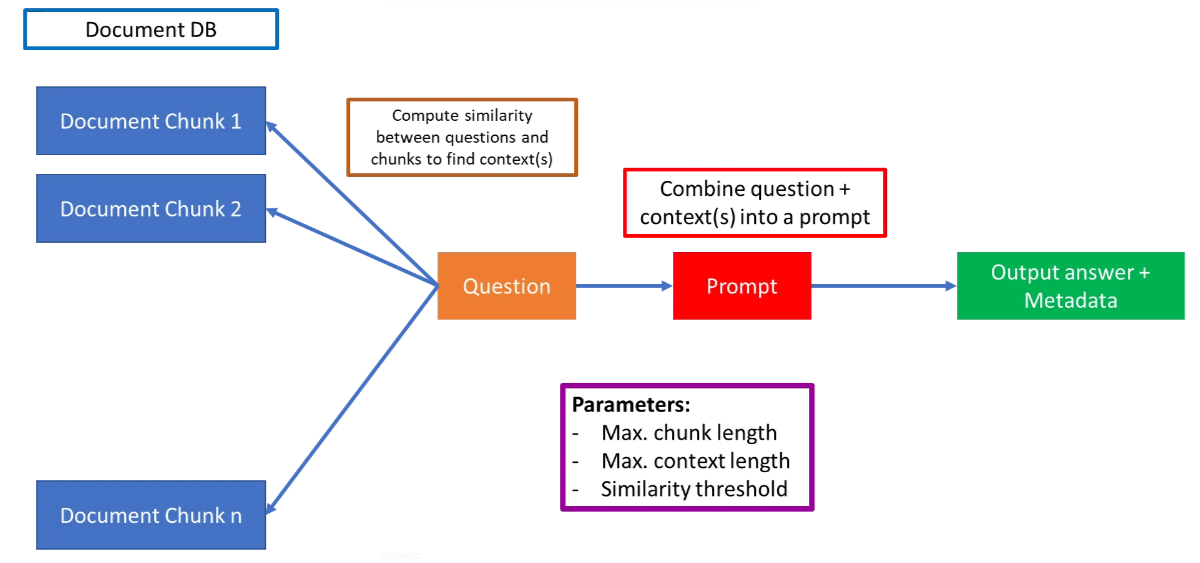

In [31]:
import pandas as pd

In [32]:
!pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 20.4 MB/s eta 0:00:00


In [33]:
import requests
import fitz
import io

url = "https://s2.q4cdn.com/299287126/files/doc_financials/2023/q1/Q1-2023-Amazon-Earnings-Release.pdf"
request = requests.get(url)
filestream = io.BytesIO(request.content)
with fitz.open(stream=filestream, filetype="pdf") as doc:
    text = ""
    for page in doc:
        text += page.get_text()
print(text[:10])

AMAZON.COM


In [34]:
def tokenize(text,max_tokens) -> pd.DataFrame:
    """ Function to split the text into chunks of a maximum number of tokens """

    # Load the cl100k_base tokenizer which is designed to work with the ada-002 model
    tokenizer = tiktoken.get_encoding("cl100k_base")

    df=pd.DataFrame(['0',text]).T
    df.columns = ['title', 'text']

    # Tokenize the text and save the number of tokens to a new column
    df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

    # Visualize the distribution of the number of tokens per row using a histogram
    # df.n_tokens.hist()

    ################################################################################
    # Step 8
    ################################################################################

    shortened = []

    # Loop through the dataframe
    for row in df.iterrows():

        # If the text is None, go to the next row
        if row[1]['text'] is None:
            continue

        # If the number of tokens is greater than the max number of tokens, split the text into chunks
        if row[1]['n_tokens'] > max_tokens:
            shortened += split_into_many(row[1]['text'], tokenizer, max_tokens)

        # Otherwise, add the text to the list of shortened texts
        else:
            shortened.append(row[1]['text'])


    df = pd.DataFrame(shortened, columns=['text'])
    df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))


    df['embeddings'] = df.text.apply(lambda x: get_embedding(x))

    return df




def split_into_many(text: str, tokenizer: tiktoken.Encoding, max_tokens: int = 1024) -> list:
    """ Function to split a string into many strings of a specified number of tokens """

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence))
                for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks

For proof of concept, try sending the entire document over the prompt and record the error you get

In [35]:
text[:100]

'AMAZON.COM ANNOUNCES FIRST QUARTER RESULTS\nSEATTLE—(BUSINESS WIRE) April 27, 2023—Amazon.com, Inc. ('

In [42]:
len(text+text)

95728

In [43]:
prompt=f"""What was the sales increase for Amazon in the first quarter based on the context below?

Context:

```
{text+text}
```
"""

print(get_completion(prompt))


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 25336 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [44]:
df = tokenize(text, 500)

In [45]:
len(df)

13

In [ ]:
df.iloc[0]['text']

'AMAZON.COM ANNOUNCES FIRST QUARTER RESULTS\nSEATTLE—(BUSINESS WIRE) April 27, 2023—Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results \nfor its first quarter ended March 31, 2023. \n•\nNet sales increased 9% to $127.4 billion in the first quarter, compared with $116.4 billion in first quarter 2022.\nExcluding the $2.4 billion unfavorable impact from year-over-year changes in foreign exchange rates throughout the\nquarter, net sales increased 11% compared with first quarter 2022.\n•\nNorth America segment sales increased 11% year-over-year to $76.9 billion.\n•\nInternational segment sales increased 1% year-over-year to $29.1 billion, or increased 9% excluding changes\nin foreign exchange rates.\n•\nAWS segment sales increased 16% year-over-year to $21.4 billion.\n•\nOperating income increased to $4.8 billion in the first quarter, compared with $3.7 billion in first quarter 2022. First\nquarter 2023 operating income includes approximately $0.5 billion of charges related t

In [46]:
def answer_question(
    df: pd.DataFrame,
    question: str
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df
    )


    prompt=f"""Answer the question based on the context provided.

    Question:
    ```{question}.```

    Context:
    ```{context}```
    """

    response = openai.chat.completions.create(
                    model="gpt-3.5-turbo",
                    temperature=0,
        messages=[{"role": "user", "content": prompt}]
    )

    return response.choices[0].message.content







def create_context(question: str, df: pd.DataFrame,max_len: int = 1800) -> str:
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = get_embedding(question)

    # Get the distances from the embeddings
    df['distances'] = df['embeddings'].apply(lambda x: spatial.distance.cosine(q_embeddings,x))
    # distances_from_embeddings(
    #     q_embeddings, df['embeddings'].values, distance_metric='cosine')

    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens']

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [47]:
answer_question(df, question="What was the sales increase for Amazon in the first quarter")

'The sales increase for Amazon in the first quarter was 9%, reaching $127.4 billion compared to $116.4 billion in the first quarter of 2022.'

In [48]:
answer_question(df, question="What was the net income for Amazon in the first quarter of 2020")

'The net income for Amazon in the first quarter of 2020 was $3.2 billion.'